In [1]:
from keras.utils import HDF5Matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils import to_categorical
from keras import backend as K
import keras.callbacks as cb
from keras.models import load_model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Conv2D, MaxPool2D, Flatten, LeakyReLU, Concatenate, GlobalAveragePooling2D, UpSampling2D
from PIL import Image

import keras
import tensorflow
import tensorflow.compat.v1 as tf

import numpy as np
import pandas as pd
import imageio
import cv2
import pprint
import h5py
import os
import PIL

import src.model as my_model
import src.pcam_loader as data
import src.adaptive_model as am

Using TensorFlow backend.


# Show if tensorflow can run with GPU
# Run tensorflow keras on multiple core

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# config = tf.ConfigProto(device_count={"CPU": 8})
# tensorflow.compat.v1.keras.backend.set_session(tf.Session(config=config))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12298686801024438904
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4854028697
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15203721058780714902
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5"
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5



In [3]:
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
# from xgboost import XGBClassifier

In [4]:
from PIL import Image
import os
import h5py
import re
import numpy as np
import pandas as pd

def create_dataset(path, dataset_type, image_size=256, pixel_shift=16):
    x_images = os.listdir(path + '/Label/')
    x_images.pop()
    dataframe = h5py.File(dataset_type + "_dataset.hdf5", "w")
    image_shape = (image_size, image_size, 1)

    for image in x_images:
        for y in range(0, 512 - image_size, pixel_shift):
            for x in range(0, 512 - image_size, pixel_shift):
                picture = Image.open(path + re.sub('_label','',image))
                label_path = path + 'Label/' + image
                cut_name = re.sub('.PNG', '', image) + '_' + str(x) + '_'+ str(y) + '.PNG'
                cut_picture = picture.crop((x, y, image_size + x, image_size + y))
                cut_picture = np.asarray(cut_picture)

                data = dataframe.create_dataset(cut_name, shape=image_shape, data=cut_picture)
                picture_label = Image.open(label_path)
                cut_picture_label = picture_label.crop((x, y, image_size + x, image_size + y))

                black_count = [1 for row in np.asarray(cut_picture_label) for column in row if not column == 0]
                if len(black_count) == 0:
                    data.attrs['class_type'] = 0
                else:
                    data.attrs['class_type'] = 1

    dataframe.close()
    

# create_dataset('./data/DAGM_KaggleUpload/Class6/Train/', 'Train', 96)
# create_dataset('./data/DAGM_KaggleUpload/Class6/Test/', 'Test', 96)

# Load DAGM data

In [5]:
def load_dataset(dataset_type, path=None):
    if path:
        dataset_type = os.path.join(path, dataset_type)
    dataset = h5py.File(dataset_type + '_dataset.hdf5', 'r')
    dataset_name = list(dataset)

    y = []
    x = []
    for name in dataset_name:
        data = dataset[name]
        y.append(data.attrs['class_type'])
        x_item = data[:]
        x.append(x_item)

    y = np.array(y)
    y = y.reshape(len(y),1)
    x = np.array(x)
    dataset.close()
    return x, y

In [6]:
x_train, y_train = load_dataset('Train', 'data')
x_test, y_test = load_dataset('Test', 'data')

In [7]:
x_valid_length = round(len(x_test)/2)

x_valid = np.array(x_test[x_valid_length:])
x_test = np.array(x_test[:x_valid_length])

y_valid = y_test[x_valid_length:]
y_test = y_test[:x_valid_length]

In [8]:
# print(meta_train.head(5), '\n')
# print(meta_train.info())

print('\n' + 'Shape of train', x_train.shape,  len(y_train), y_train.shape)
print('Shape of valid', x_valid.shape,  len(y_valid), y_valid.shape)
print('Shape of test', x_test.shape, len(y_test), y_test.shape)


Shape of train (55432, 96, 96, 1) 55432 (55432, 1)
Shape of valid (22308, 96, 96, 1) 22308 (22308, 1)
Shape of test (22308, 96, 96, 1) 22308 (22308, 1)


# Load pcam data

In [3]:
# Load data from /User/Username/.keras/datasets/pcam
dataset = data.load_data()
x_train, y_train, meta_train =  dataset[0]
x_valid, y_valid, meta_valid =  dataset[1]
x_test, y_test, meta_test =  dataset[2]

C:\Users\matho\Anaconda3\lib\site-packages\keras\utils\io_utils.py:60: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(datapath)


In [4]:
y_train = np.array(y_train[:])
y_train = y_train.reshape(-1, 1)
y_valid = np.array(y_valid[:])
y_valid = y_valid.reshape(-1, 1)
y_test = np.array(y_test[:])
y_test = y_test.reshape(-1, 1)

In [5]:
from IPython.display import Image as ShowPicture

# from PIL import Image
# from numpy import *

# # im = array(Image.open('image.jpg'))
# Image.fromarray(x_test[0]).save('PCAM_1.png')
# ShowPicture(filename='./data/obrazky/image.png') 

In [6]:
print(meta_train.head(5), '\n')
print(meta_train.info())

# Shape of train, valid and test input are the same, don't need to preprocess
print('\n' + 'Shape of train', x_train.shape,  len(y_train), y_train.shape)
print('Shape of valid', x_valid.shape,  len(y_valid), y_valid.shape)
print('Shape of test', x_test.shape, len(y_test), y_test.shape)

   Unnamed: 0  coord_y  coord_x  tumor_patch  center_tumor_patch  \
0           0    63104    43648        False               False   
1           1   148544    74048         True                True   
2           2    64192    78912         True                True   
3           3    98048    72128         True                True   
4           4    27264    50688        False               False   

                           wsi  
0   camelyon16_train_tumor_104  
1   camelyon16_train_tumor_003  
2   camelyon16_train_tumor_089  
3   camelyon16_train_tumor_004  
4  camelyon16_train_normal_118   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262144 entries, 0 to 262143
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Unnamed: 0          262144 non-null  int64 
 1   coord_y             262144 non-null  int64 
 2   coord_x             262144 non-null  int64 
 3   tumor_patch         262144 non-

# Build model

In [7]:
batch_size = 10
epochs = 10
num_classes = 2
shape = (96, 96, 3)

## Backpropagation

In [5]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_backpropagation332.h5'

# layers = am.unet_layer(input_layer, 7, 16) 
# layers = am.unet_layer(input_layer, 5, 16) 
# layers = am.unet_layer(input_layer, 3, 16) 

# layers = am.unet_layer(input_layer, 7, 32)
# layers = am.unet_layer(input_layer, 5, 32)
layers = am.unet_layer(input_layer, 3, 32)
# Test loss: 0.2707285643226222 Precision: 0.9579018354415894 Accuracy: 0.934381365776062 Recall: 0.9579018354415894 TruePositives: 765252.25 FalsePositives: 33631.66796875 FalseNegatives: 33631.66796875 F1_score 0.9459953746919001 

# layers = am.unet_layer(input_layer, 7, 64) 
# layers = am.unet_layer(input_layer, 5, 64) 
# layers = am.unet_layer(input_layer, 3, 64) 

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

## Autoencoder

In [34]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_autoencoder332.h5'

# layers = am.encoder_layer(input_layer, 7, 16) 
# layers = am.encoder_layer(input_layer, 5, 16) 
# layers = am.encoder_layer(input_layer, 3, 16) 

# layers = am.encoder_layer(input_layer, 7, 32) 
# layers = am.encoder_layer(input_layer, 5, 32) 
layers = am.encoder_layer(input_layer, 3, 32)

# layers = am.encoder_layer(input_layer, 7, 64) 
# layers = am.encoder_layer(input_layer, 5, 64) 
# layers = am.encoder_layer(input_layer, 3, 64) 

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

## Gabor kernels

In [12]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_gabor532.h5'

# layers = am.gabor_layer(input_layer, 9, 16) 
# layers = am.gabor_layer(input_layer, 7, 16) 
# layers = am.gabor_layer(input_layer, 5, 16) 

layers = am.gabor_layer(input_layer, 9, 32) 
# layers = am.gabor_layer(input_layer, 7, 32)
# layers = am.gabor_layer(input_layer, 5, 32)
# Test loss: 0.31318365948966587 Precision: 0.9474299550056458 Accuracy: 0.9329683184623718 Recall: 0.9474299550056458 TruePositives: 756883.8125 FalsePositives: 41999.8125 FalseNegatives: 41999.8125 F1_score 0.940143476461619

# layers = am.gabor_layer(input_layer, 9, 64) 
# layers = am.gabor_layer(input_layer, 7, 64) 
# layers = am.gabor_layer(input_layer, 5, 64) 

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

# Add filters from gabor function
weights, gabor_filters = am.gabor_filter(model)
model.layers[1].set_weights(weights)

print(model.layers[1].get_weights()[0].shape)

(9, 9, 3, 32)


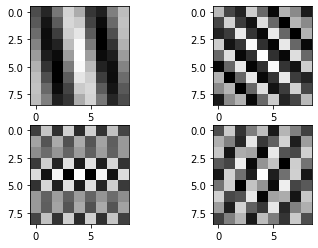

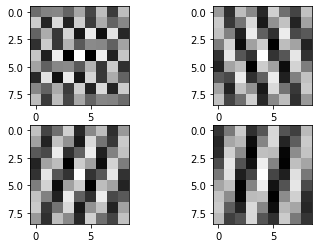

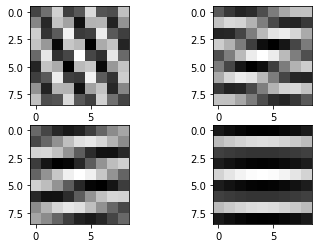

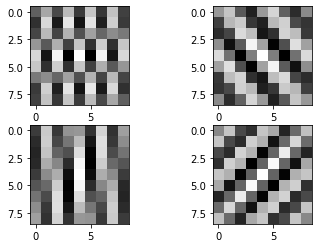

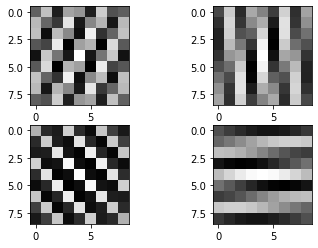

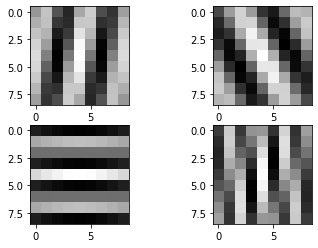

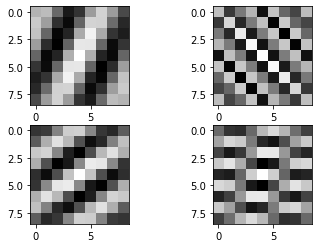

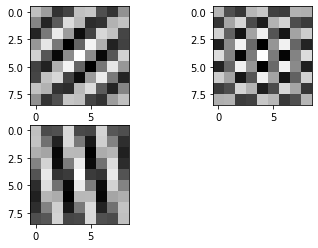

<Figure size 432x288 with 0 Axes>

In [16]:
# Show Filters
f = np.asarray(gabor_filters)
import pylab as pl
# for k,im in enumerate(f):
#     pl.subplot(2,2,k+1)
#     pl.imshow(im, cmap='gray')
# pl.savefig('gabor_filter.png')
# pl.show()

for i in range(1,5):
    pl.subplot(2,2,i)
    pl.imshow(f[i],cmap="gray")
pl.show()
pl.savefig('gf1.png')
for i in range(1,5):
    pl.subplot(2,2,i)
    pl.imshow(f[i + 4],cmap="gray")
pl.show()
pl.savefig('gf2.png')
for i in range(1,5):
    pl.subplot(2,2,i)
    pl.imshow(f[i + 8],cmap="gray")
pl.show()
pl.savefig('gf3.png')
for i in range(1,5):
    pl.subplot(2,2,i)
    pl.imshow(f[i + 12],cmap="gray")
pl.show()
pl.savefig('gf4.png')
for i in range(1,5):
    pl.subplot(2,2,i)
    pl.imshow(f[i + 16],cmap="gray")
pl.show()
pl.savefig('gf5.png')
for i in range(1,5):
    pl.subplot(2,2,i)
    pl.imshow(f[i + 20],cmap="gray")
pl.show()
pl.savefig('gf6.png')
for i in range(1,5):
    pl.subplot(2,2,i)
    pl.imshow(f[i + 24],cmap="gray")
pl.show()
pl.savefig('gf7.png')
for i in range(1,4):
    pl.subplot(2,2,i)
    pl.imshow(f[i + 28],cmap="gray")
pl.show()
pl.savefig('gf8.png')
# loaded_model.layers[1].get_weights()[0]

## Transfer learning

In [8]:
from keras.applications import MobileNet
from keras import applications
model_name = 'adaptive_transfer.h5'

# # Transform data to RGB
# x_train = np.ndarray(shape=(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3), dtype= np.uint8) 
# x_valid = np.ndarray(shape=(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 3), dtype= np.uint8) 
# x_test = np.ndarray(shape=(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3), dtype= np.uint8) 

# Use ImageNet as first 'layers'
# base_model= applications.VGG16(weights = "imagenet", include_top=False)
# Test loss: 0.64473734570615 Precision: 0.6710929870605469 Accuracy: 0.6557890772819519 Recall: 0.6710929870605469 TruePositives: 536124.6875 FalsePositives: 262759.3125 FalseNegatives: 262759.3125 F1_score 0.6633527265368022 
base_model= applications.resnet.ResNet152(weights = "imagenet", include_top=False)
layer = base_model.output

# Use Unet architecture as main model
# outputs_layer = am.unet_model(layer)

# Output layer
outputs_layer = am.transfer_layer(layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(base_model.input, outputs_layer)
    
for layer in model.layers[:15]:
    layer.trainable=False
for layer in model.layers[15:]:
    layer.trainable=True
    
# for layer in model.layers[:20]:
#     layer.trainable=False
# for layer in model.layers[30:]:
#     layer.trainable=True
    
# for layer in model.layers[:25]:
#     layer.trainable=False
# for layer in model.layers[25:]:
#     layer.trainable=True

# for layer in model.layers[:30]:
#     layer.trainable=False
# for layer in model.layers[30:]:
#     layer.trainable=True

## Own Metrics

In [9]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    result = true_positives / (possible_positives + K.epsilon())
    return result


def my_own_preci(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    result = true_positives / (predicted_positives + K.epsilon())
    return result


def f1_score_metrics(y_true, y_pred):
    precision_result = precision(y_true, y_pred)
    recall_result = recall(y_true, y_pred)
    return 2*((precision_result*recall_result)/(precision_result+recall_result+K.epsilon()))


def f1_score_evaluate(precision, recall):
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Compile and train the model

In [10]:
callbacks = [
    cb.callbacks.ModelCheckpoint(model_name, save_best_only=True)
#     cb.callbacks.EarlyStopping(monitor = 'val_loss'),
#     cb.callbacks.CSVLogger('model.csv', separator=',', append=False),
#     cb.tensorboard_v1.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
]

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=[
                  tensorflow.keras.metrics.Precision(),
                  'accuracy',
                  tensorflow.keras.metrics.Recall(),
                  tensorflow.keras.metrics.TruePositives(),
                  tensorflow.keras.metrics.FalsePositives(),
                  tensorflow.keras.metrics.FalseNegatives()
                      ])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [11]:
history = model.fit(
    x_train,
    to_categorical(y_train),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_valid, to_categorical(y_valid)),
    shuffle='batch',
    callbacks=callbacks,
    use_multiprocessing=True, 
    workers=8
)

Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 7631s 29ms/step - loss: 0.5070 - precision: 0.5762 - accuracy: 0.7078 - recall: 0.5762 - true_positives: 80551.8281 - false_positives: 50527.9219 - false_negatives: 50527.9219 - val_loss: 1.2682 - val_precision: 0.6956 - val_accuracy: 0.5002 - val_recall: 0.6956 - val_true_positives: 193697.9062 - val_false_positives: 84835.3594 - val_false_negatives: 84835.3594
Epoch 2/10
262144/262144 [==============================] - 7654s 29ms/step - loss: 0.2136 - precision: 0.7495 - accuracy: 0.9160 - recall: 0.7495 - true_positives: 321593.5625 - false_positives: 104398.7891 - false_negatives: 104398.7891 - val_loss: 1.5160 - val_precision: 0.7851 - val_accuracy: 0.4986 - val_recall: 0.7851 - val_true_positives: 450176.9688 - val_false_positives: 123269.5234 - val_false_negatives: 123269.5234
Epoch 3/10
262144/262144 [==============================] - 7650s 29ms/step - loss: 0.1785 - p

In [12]:
model.save('eop_' + model_name)

# Evaluate the model

In [13]:
test_eval = model.evaluate(x_test, to_categorical(y_test), verbose=0)
f1_score = f1_score_evaluate(test_eval[2], test_eval[3])

In [14]:
print('Test loss:', test_eval[0],end=' ')
print('Precision:', test_eval[1],end=' ')
print('Accuracy:', test_eval[2],end=' ')
print('Recall:', test_eval[3],end=' ')
print('TruePositives:', test_eval[4],end=' ')
print('FalsePositives:', test_eval[5],end=' ')
print('FalseNegatives:', test_eval[6],end=' ')
print('F1_score', f1_score,end=' ')

Test loss: 309.10254266308186 Precision: 0.8782198429107666 Accuracy: 0.58160400390625 Recall: 0.8782198429107666 TruePositives: 2604368.0 FalsePositives: 361150.65625 FalseNegatives: 361150.65625 F1_score 0.6997777753413489 

### Predict on model ( real evaluate ) 

In [15]:
y_pred = model.predict(x_test, verbose=0, workers=8, use_multiprocessing=True)

In [16]:
print('My precision', my_own_preci(to_categorical(y_test), y_pred))
print('My recall', recall(to_categorical(y_test), y_pred))

My precision tf.Tensor(0.581604, shape=(), dtype=float32)
My recall tf.Tensor(0.581604, shape=(), dtype=float32)


### Graf from training

In [17]:
print('Name of model is', model_name)

Name of model is adaptive_transfer.h5


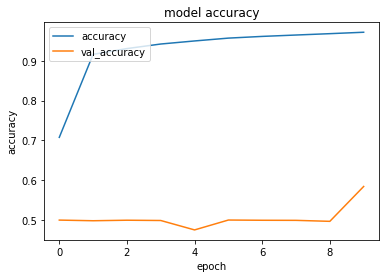

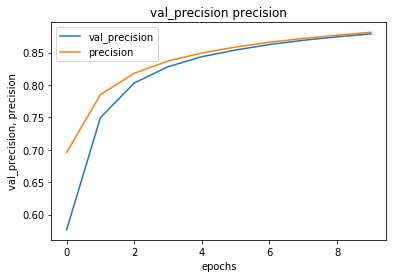

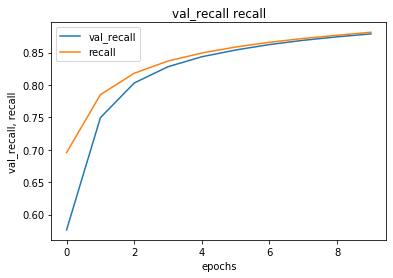

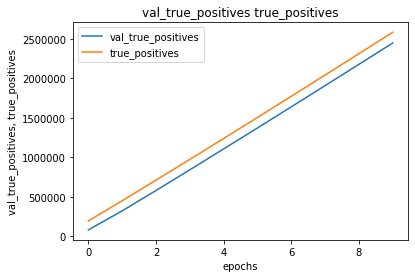

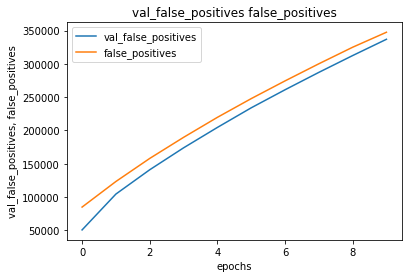

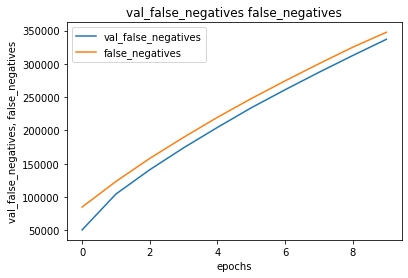

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()


plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('val_precision precision')
plt.ylabel('val_precision, precision')
plt.xlabel('epochs')
plt.legend(['val_precision', 'precision'], loc='upper left')
plt.show()


plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('val_recall recall')
plt.ylabel('val_recall, recall')
plt.xlabel('epochs')
plt.legend(['val_recall', 'recall'], loc='upper left')
plt.show()

plt.plot(history.history['true_positives'])
plt.plot(history.history['val_true_positives'])
plt.title('val_true_positives true_positives')
plt.ylabel('val_true_positives, true_positives')
plt.xlabel('epochs')
plt.legend(['val_true_positives', 'true_positives'], loc='upper left')
plt.show()

plt.plot(history.history['false_positives'])
plt.plot(history.history['val_false_positives'])
plt.title('val_false_positives false_positives')
plt.ylabel('val_false_positives, false_positives')
plt.xlabel('epochs')
plt.legend(['val_false_positives', 'false_positives'], loc='upper left')
plt.show()

plt.plot(history.history['false_negatives'])
plt.plot(history.history['val_false_negatives'])
plt.title('val_false_negatives false_negatives')
plt.ylabel('val_false_negatives, false_negatives')
plt.xlabel('epochs')
plt.legend(['val_false_negatives', 'false_negatives'], loc='upper left')
plt.show()

In [19]:
test_positives = 0
test_negatives = 0
pred_positives = 0
pred_negatives = 0
for value in to_categorical(y_test):
#     print(value)
    if value[0] == 0:
        test_positives += 1
    else:
        test_negatives += 1
        
for value in K.round(K.clip(y_pred, 0, 1)):
#     print(value)
    if value[0] == 0:
        pred_positives += 1
    else:
        pred_negatives += 1        

print(test_positives)
print(test_negatives)
print(pred_positives)
print(pred_negatives)

16377
16391
26935
5833


## Load model

In [46]:
custom_objects = {}
custom_objects["precision"] = 'tensorflow.keras.metrics.Precision'
custom_objects["recall"] = 'tensorflow.keras.metrics.Recall'
custom_objects["true_positives"] = 'tensorflow.keras.metrics.TruePositives'
custom_objects["false_positives"] = 'tensorflow.keras.metrics.FalsePositives'
custom_objects["false_negatives"] = 'tensorflow.keras.metrics.FalseNegatives'


# loaded_model = tf.keras.models.load_model('adaptive_autoencoder764.h5', custom_objects=custom_objects)
loaded_model = tf.keras.models.load_model('adaptive_gabor964.h5', custom_objects=custom_objects)
# loaded_model = tf.keras.models.load_model('adaptive_backpropagation732.h5', custom_objects=custom_objects)

## Vizualize filters

In [ ]:
x1w = model.layers[1].get_weights()[0][:,:,0,:]
for i in range(1,5):
    pl.subplot(2,2,i)
    pl.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
pl.show()
for i in range(1,5):
    pl.subplot(2,2,i)
    pl.imshow(x1w[:,:,i + 10],interpolation="nearest",cmap="gray")
pl.show()
for i in range(1,5):
    pl.subplot(2,2,i)
    pl.imshow(x1w[:,:,i + 20],interpolation="nearest",cmap="gray")
pl.show()
for i in range(1,5):
    pl.subplot(2,2,i)
    pl.imshow(x1w[:,:,i + 30],interpolation="nearest",cmap="gray")
pl.show()
# loaded_model.layers[1].get_weights()[0]

### Evaluate the best model

In [36]:
test_eval = loaded_model.evaluate(x_test, to_categorical(y_test), verbose=0)
f1_score = f1_score_evaluate(test_eval[2], test_eval[3])

In [37]:
print('Test loss:', test_eval[0],end=' ')
print('Precision:', test_eval[1],end=' ')
print('Accuracy:', test_eval[2],end=' ')
print('Recall:', test_eval[3],end=' ')
print('TruePositives:', test_eval[4],end=' ')
print('FalsePositives:', test_eval[5],end=' ')
print('FalseNegatives:', test_eval[6],end=' ')
print('F1_score', f1_score,end=' ')

Test loss: 0.15854895245152015 Precision: 0.9511386 Accuracy: 0.9511386 Recall: 0.9511386 TruePositives: 21218.0 FalsePositives: 1090.0 FalseNegatives: 1090.0 F1_score 0.951138596268097 

In [38]:
y_pred = loaded_model.predict(x_test.astype('float16'), verbose=0, workers=8, use_multiprocessing=True)

In [39]:
print('My precision', my_own_preci(to_categorical(y_test), y_pred))
print('My recall', recall(to_categorical(y_test), y_pred))

My precision tf.Tensor(0.9511386, shape=(), dtype=float32)
My recall tf.Tensor(0.9511386, shape=(), dtype=float32)


In [40]:
test_positives = 0
test_negatives = 0
pred_positives = 0
pred_negatives = 0
for value in to_categorical(y_test):
#     print(value)
    if value[0] == 0:
        test_positives += 1
    else:
        test_negatives += 1
        
for value in K.round(K.clip(y_pred, 0, 1)):
#     print(value)
    if value[0] == 0:
        pred_positives += 1
    else:
        pred_negatives += 1        

print(test_positives)
print(test_negatives)
print(pred_positives)
print(pred_negatives)

7731
14577
6797
15511
